<a href="https://colab.research.google.com/github/crazyboyonline/Recommender-Systems/blob/main/%E6%96%B0%E9%97%BB%E6%8E%A8%E8%8D%90_%E6%95%B0%E6%8D%AE%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip '/content/drive/MyDrive/新闻推荐/新闻推荐.zip' -d '/content/drive/MyDrive/新闻推荐'

Archive:  /content/drive/MyDrive/新闻推荐/新闻推荐.zip
  inflating: /content/drive/MyDrive/新闻推荐/articles.csv  
  inflating: /content/drive/MyDrive/新闻推荐/articles_emb.csv  
  inflating: /content/drive/MyDrive/新闻推荐/testA_click_log.csv  
  inflating: /content/drive/MyDrive/新闻推荐/train_click_log.csv  


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='SimHei', size=13)

import os,gc,re,warnings,sys
warnings.filterwarnings("ignore")

#读取数据

In [5]:
# path = './data/' # 自定义的路径
path = '/content/drive/MyDrive/新闻推荐/' # 路径

#####train
trn_click = pd.read_csv(path+'train_click_log.csv')
#trn_click = pd.read_csv(path+'train_click_log.csv', names=['user_id','item_id','click_time','click_environment','click_deviceGroup','click_os','click_country','click_region','click_referrer_type'])
item_df = pd.read_csv(path+'articles.csv')
item_df = item_df.rename(columns={'article_id': 'click_article_id'})  #重命名，方便后续match
item_emb_df = pd.read_csv(path+'articles_emb.csv')

#####test
tst_click = pd.read_csv(path+'testA_click_log.csv')

#数据预处理
计算用户点击rank和点击次数


In [6]:
# 对每个用户的点击时间戳进行排序
trn_click['rank'] = trn_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)
tst_click['rank'] = tst_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)

In [7]:
#计算用户点击文章的次数，并添加新的一列count
trn_click['click_cnts'] = trn_click.groupby(['user_id'])['click_timestamp'].transform('count')
tst_click['click_cnts'] = tst_click.groupby(['user_id'])['click_timestamp'].transform('count')

#数据浏览
用户点击日志文件_训练集

In [8]:
trn_click = trn_click.merge(item_df, how='left', on=['click_article_id'])
trn_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,199999,160417,1507029570190,4,1,17,1,13,1,11,11,281,1506942089000,173
1,199999,5408,1507029571478,4,1,17,1,13,1,10,11,4,1506994257000,118
2,199999,50823,1507029601478,4,1,17,1,13,1,9,11,99,1507013614000,213
3,199998,157770,1507029532200,4,1,17,1,25,5,40,40,281,1506983935000,201
4,199998,96613,1507029671831,4,1,17,1,25,5,39,40,209,1506938444000,185


#train_click_log.csv文件数据中每个字段的含义
user_id: 用户的唯一标识 
click_article_id: 用户点击的文章唯一标识
click_timestamp: 用户点击文章时的时间戳
click_environment: 用户点击文章的环境
click_deviceGroup: 用户点击文章的设备组
click_os: 用户点击文章时的操作系统
click_country: 用户点击文章时的所在的国家
click_region: 用户点击文章时所在的区域
click_referrer_type: 用户点击文章时，文章的来源









In [9]:
trn_click.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1112623 entries, 0 to 1112622
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   user_id              1112623 non-null  int64
 1   click_article_id     1112623 non-null  int64
 2   click_timestamp      1112623 non-null  int64
 3   click_environment    1112623 non-null  int64
 4   click_deviceGroup    1112623 non-null  int64
 5   click_os             1112623 non-null  int64
 6   click_country        1112623 non-null  int64
 7   click_region         1112623 non-null  int64
 8   click_referrer_type  1112623 non-null  int64
 9   rank                 1112623 non-null  int64
 10  click_cnts           1112623 non-null  int64
 11  category_id          1112623 non-null  int64
 12  created_at_ts        1112623 non-null  int64
 13  words_count          1112623 non-null  int64
dtypes: int64(14)
memory usage: 127.3 MB


In [10]:
trn_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
count,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06
mean,1.221198e+05,1.951541e+05,1.507588e+12,3.947786e+00,1.815981e+00,1.301976e+01,1.310776e+00,1.813587e+01,1.910063e+00,7.118518e+00,1.323704e+01,3.056176e+02,1.506598e+12,2.011981e+02
std,5.540349e+04,9.292286e+04,3.363466e+08,3.276715e-01,1.035170e+00,6.967844e+00,1.618264e+00,7.105832e+00,1.220012e+00,1.016095e+01,1.631503e+01,1.155791e+02,8.343066e+09,5.223881e+01
min,0.000000e+00,3.000000e+00,1.507030e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.166573e+12,0.000000e+00
25%,7.934700e+04,1.239090e+05,1.507297e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,2.000000e+00,4.000000e+00,2.500000e+02,1.507220e+12,1.700000e+02
50%,1.309670e+05,2.038900e+05,1.507596e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00,4.000000e+00,8.000000e+00,3.280000e+02,1.507553e+12,1.970000e+02
75%,1.704010e+05,2.777120e+05,1.507841e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00,8.000000e+00,1.600000e+01,4.100000e+02,1.507756e+12,2.280000e+02
max,1.999990e+05,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00,2.410000e+02,2.410000e+02,4.600000e+02,1.510666e+12,6.690000e+03


In [11]:
#训练集中的用户数量为20w
trn_click.user_id.nunique()

200000

In [12]:
trn_click.groupby('user_id')['click_article_id'].count().min()  # 训练集里面每个用户至少点击了两篇文章

2

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.
findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

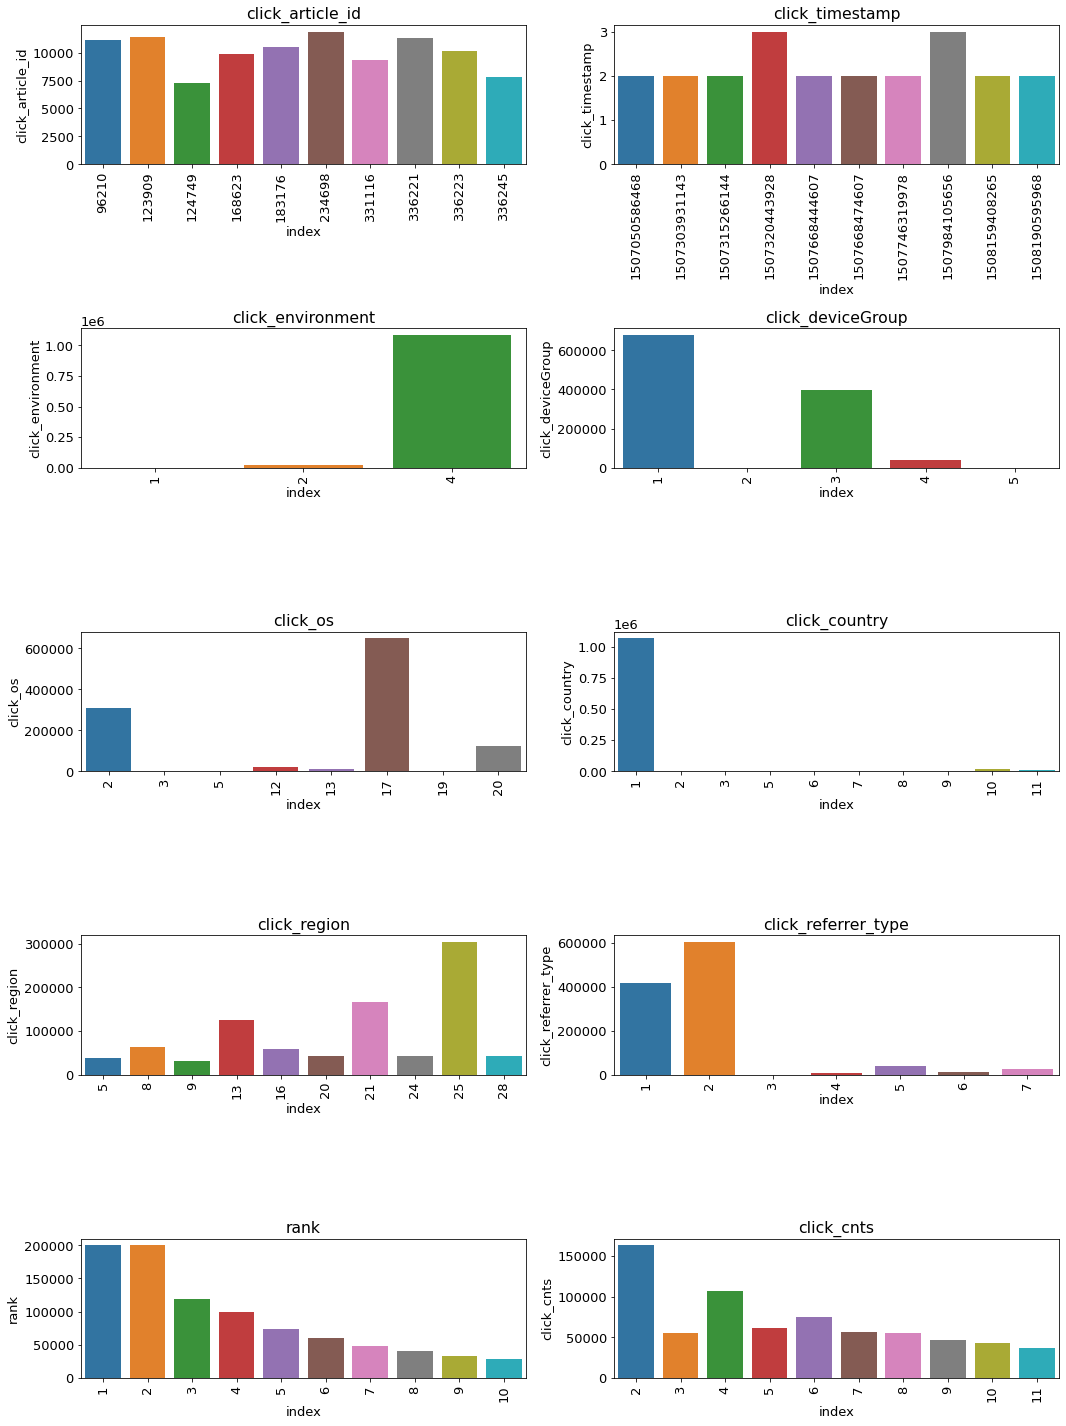

In [13]:
plt.figure()
plt.figure(figsize=(15, 20))
i = 1
for col in ['click_article_id', 'click_timestamp', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 
            'click_region', 'click_referrer_type', 'rank', 'click_cnts']:
    plot_envs = plt.subplot(5, 2, i)
    i += 1
    v = trn_click[col].value_counts().reset_index()[:10]
    fig = sns.barplot(x=v['index'], y=v[col])
    for item in fig.get_xticklabels():
        item.set_rotation(90)
    plt.title(col)
plt.tight_layout()
plt.show()

也可以以用户角度分析，画出每个用户点击文章次数的直方图



In [14]:
trn_click['click_environment'].value_counts()

4    1084627
2      25894
1       2102
Name: click_environment, dtype: int64

从点击环境click_environment来看，仅有2102次（占0.19%）点击环境为1；仅有25894次（占2.3%）点击环境为2；剩余（占97.6%）点击环境为4。

In [15]:
trn_click['click_deviceGroup'].value_counts()

1    678187
3    395558
4     38731
5       141
2         6
Name: click_deviceGroup, dtype: int64

从点击设备组click_deviceGroup来看，设备1占大部分（61%），设备3占36%。

#测试集用户点击日志

In [16]:
tst_click = tst_click.merge(item_df,how = 'left', on = ['click_article_id'])
tst_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,249999,160974,1506959142820,4,1,17,1,13,2,19,19,281,1506912747000,259
1,249999,160417,1506959172820,4,1,17,1,13,2,18,19,281,1506942089000,173
2,249998,160974,1506959056066,4,1,12,1,13,2,5,5,281,1506912747000,259
3,249998,202557,1506959086066,4,1,12,1,13,2,4,5,327,1506938401000,219
4,249997,183665,1506959088613,4,1,17,1,15,5,7,7,301,1500895686000,256


In [17]:
tst_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
count,518010.000000,518010.000000,5.180100e+05,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,5.180100e+05,518010.000000
mean,227342.428169,193803.792550,1.507387e+12,3.947300,1.738285,13.628467,1.348209,18.250250,1.819614,15.521785,30.043586,305.324961,1.506883e+12,210.966331
std,14613.907188,88279.388177,3.706127e+08,0.323916,1.020858,6.625564,1.703524,7.060798,1.082657,33.957702,56.868021,110.411513,5.816668e+09,83.040065
min,200000.000000,137.000000,1.506959e+12,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.265812e+12,0.000000
25%,214926.000000,128551.000000,1.507026e+12,4.000000,1.000000,12.000000,1.000000,13.000000,1.000000,4.000000,10.000000,252.000000,1.506970e+12,176.000000
50%,229109.000000,199197.000000,1.507308e+12,4.000000,1.000000,17.000000,1.000000,21.000000,2.000000,8.000000,19.000000,323.000000,1.507249e+12,199.000000
75%,240182.000000,272143.000000,1.507666e+12,4.000000,3.000000,17.000000,1.000000,25.000000,2.000000,18.000000,35.000000,399.000000,1.507630e+12,232.000000
max,249999.000000,364043.000000,1.508832e+12,4.000000,5.000000,20.000000,11.000000,28.000000,7.000000,938.000000,938.000000,460.000000,1.509949e+12,3082.000000


我们可以看出训练集和测试集的用户是完全不一样的

训练集的用户ID由0 ~ 199999，而测试集A的用户ID由200000 ~ 249999。

因此，也就是我们在训练时，需要把测试集的数据也包括在内，称为全量数据。

In [18]:
#测试集中的用户数量为5W
tst_click.user_id.nunique()

50000

In [19]:
tst_click.groupby('user_id')['click_article_id'].count().min()#注意测试集里面有只点击过一次文章的用户

1

In [20]:
#新闻文章数据集浏览
item_df.head().append(item_df.tail())

,click_article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162
364042,364042,460,1434034118000,144
364043,364043,460,1434148472000,463
364044,364044,460,1457974279000,177
364045,364045,460,1515964737000,126
364046,364046,460,1505811330000,479


In [22]:
item_df['words_count'].value_counts()

176     3485
182     3480
179     3463
178     3458
174     3456
        ... 
556        1
625        1
2798       1
767        1
841        1
Name: words_count, Length: 866, dtype: int64

461


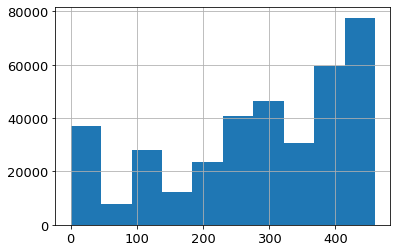

In [23]:
print(item_df['category_id'].nunique())
item_df['category_id'].hist()

In [24]:
item_df.shape #364047篇文章

(364047, 4)

#新闻文章embedding向量表示

In [25]:
item_emb_df.head()

,article_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,...,emb_210,emb_211,emb_212,emb_213,emb_214,emb_215,emb_216,emb_217,emb_218,emb_219,emb_220,emb_221,emb_222,emb_223,emb_224,emb_225,emb_226,emb_227,emb_228,emb_229,emb_230,emb_231,emb_232,emb_233,emb_234,emb_235,emb_236,emb_237,emb_238,emb_239,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249
0,0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,0.428434,0.355056,0.874437,-0.528883,0.625487,0.268920,-0.822835,-0.703853,-0.625845,-0.152855,-0.666241,0.043295,0.178638,0.046890,0.594531,-0.183348,0.195107,-0.467640,-0.304807,0.353175,0.278188,0.538623,-0.371209,0.489898,-0.103833,0.119174,0.132437,-0.621084,-0.453311,...,0.764381,0.275644,-0.692138,-0.393240,-0.325693,0.163377,-0.154952,-0.701639,0.711825,-0.839063,-0.459145,0.919913,0.621834,-0.640471,0.389934,0.764178,0.164851,-0.747023,0.411034,0.750901,0.860643,0.614755,0.549660,0.334437,-0.388059,-0.703730,-0.567420,0.006478,-0.206590,-0.385272,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,0.672840,-0.011180,-0.347506,-0.541346,0.458492,0.482316,0.713665,-0.474050,0.405787,0.671431,-0.480856,0.434779,0.468499,0.376424,0.368048,0.192545,0.095572,-0.542234,0.065547,0.363267,-0.162804,0.319617,0.469473,0.578466,-0.803637,-0.304545,0.635511,0.089978,-0.569946,...,0.344321,-0.534050,0.728764,0.860110,-0.028166,0.491114,0.531556,0.545350,-0.241544,-0.091119,0.001625,0.950923,-0.367805,-0.215411,-0.131891,0.709081,0.612876,0.814885,0.278680,0.003690,-0.286773,-0.100936,-0.382605,-0.191886,-0.416420,-0.856593,0.537442,0.281693,-0.681829,0.666095,-0.487843,0.823124,0.412688,-0.338654,0.320786,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,0.670484,-0.280388,-0.557285,-0.084145,0.027782,0.294074,0.362697,-0.368549,0.147960,-0.011751,0.030209,0.106317,0.628013,0.388849,0.615911,-0.445113,0.106028,0.137109,-0.095536,0.342532,0.592646,-0.261791,0.342123,0.704539,-0.433067,0.104154,0.785971,0.588640,-0.627687,...,-0.600840,-0.539323,0.418196,0.028715,0.135008,-0.313483,0.744361,-0.145113,-0.485484,-0.591555,0.030112,0.952736,-0.569376,-0.359680,0.561676,0.381671,-0.189300,0.420950,0.022337,-0.329559,0.232765,0.424368,-0.484598,0.394343,-0.329527,-0.852293,0.634992,-0.532673,-0.469396,0.714991,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,0.591640,-0.245205,-0.788418,-0.345293,-0.756407,0.141115,0.283782,-0.369959,0.374733,0.922633,0.172219,0.253582,0.552108,-0.454131,0.385160,-0.151101,0.598559,-0.614190,-0.258765,0.591907,0.618749,0.414598,0.698184,-0.114862,-0.069056,-0.420455,0.589368,0.496948,-0.449707,...,-0.137121,-0.245490,0.170559,0.568090,-0.252295,-0.455726,0.756765,0.626615,-0.005399,-0.472355,0.324625,0.954345,-0.840553,-0.800332,0.111637,-0.501806,0.115986,0.805840,-0.041481,0.320630,-0.450113,-0.378700,0.509616,0.142787,0.149670,-0.896181,0.234389,-0.189831,-0.597612,0.263807,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,0.698668,0.467503,-0.740664,-0.258062,-0.094110,0.256941,0.582071,-0.025041,0.339164,-0.348473,0.413076,0.159945,0.511137,0.608007,0.626225,-0.540690,0.623640,-0.019697,0.027607,-0.236370,0.311671,-0.559831,0.766381,0.412553,-0.663338,0.154626,0.708132,0.214954,-0.829963,...,0.23

In [26]:
item_emb_df.shape

(364047, 251)

#数据分析
用户重复点击

In [27]:
#merge
user_click_merge = trn_click.append(tst_click)

In [31]:
#用户重复点击
user_click_count = user_click_merge.groupby(['user_id','click_article_id'])['click_timestamp'].agg({'count'}).reset_index()
user_click_count[:10]

,user_id,click_article_id,count
0,0,30760,1
1,0,157507,1
2,1,63746,1
3,1,289197,1
4,2,36162,1
5,2,168401,1
6,3,36162,1
7,3,50644,1
8,4,39894,1
9,4,42567,1


In [32]:
user_click_count[user_click_count['count'] > 7]

,user_id,click_article_id,count
311242,86295,74254,10
311243,86295,76268,10
393761,103237,205948,10
393763,103237,235689,10
576902,134850,69463,13


In [33]:
user_click_count['count'].unique()

array([ 1,  2,  4,  3,  6,  5, 10,  7, 13])

In [34]:
#用户点击新闻次数
user_click_count.loc[:,'count'].value_counts()

1     1605541
2       11621
3         422
4          77
5          26
6          12
10          4
7           3
13          1
Name: count, dtype: int64

可以看出：有1605541（约占99.2%）的用户未重复阅读过文章，仅有极少数用户重复点击过某篇文章。 这个也可以单独制作成特征


#用户点击环境变化分析

In [35]:
def plot_envs(df, cols, r, c):
    plt.figure()
    plt.figure(figsize=(10, 5))
    i = 1
    for col in cols:
        plt.subplot(r, c, i)
        i += 1
        v = df[col].value_counts().reset_index()
        fig = sns.barplot(x=v['index'], y=v[col])
        for item in fig.get_xticklabels():
            item.set_rotation(90)
        plt.title(col)
    plt.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

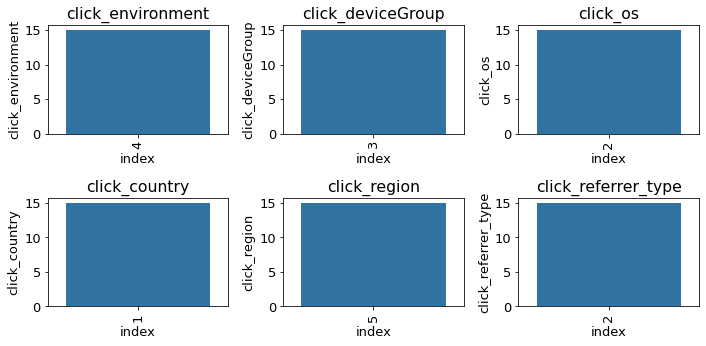

<Figure size 432x288 with 0 Axes>

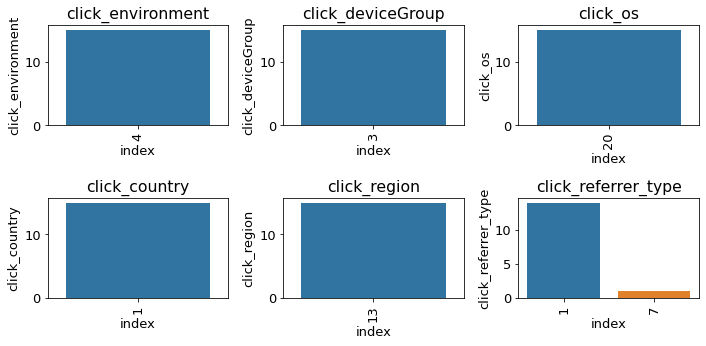

<Figure size 432x288 with 0 Axes>

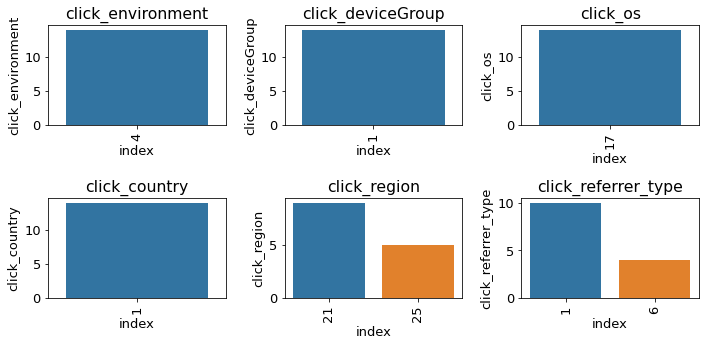

<Figure size 432x288 with 0 Axes>

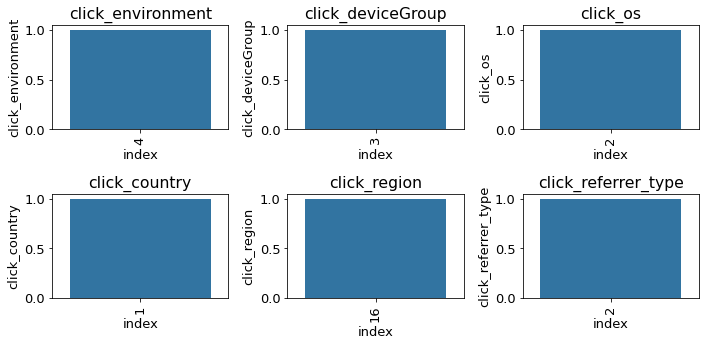

<Figure size 432x288 with 0 Axes>

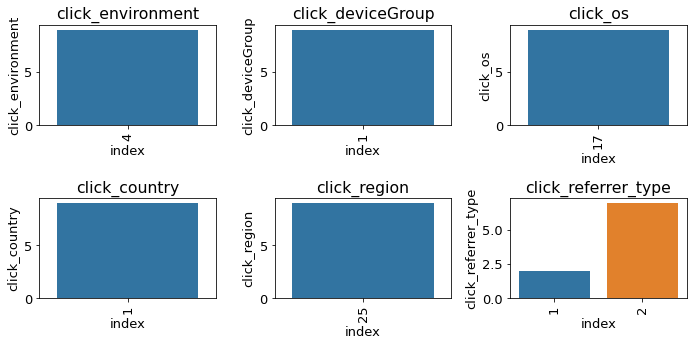

<Figure size 432x288 with 0 Axes>

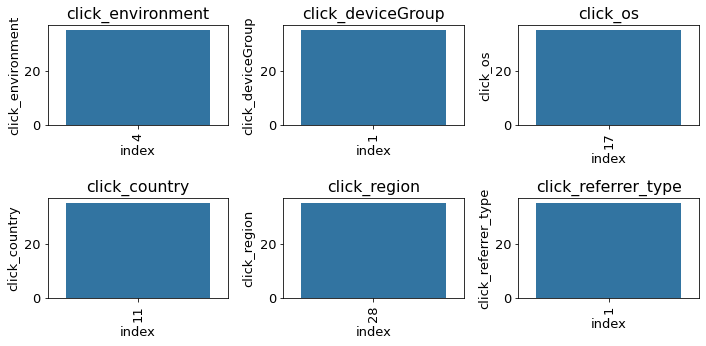

<Figure size 432x288 with 0 Axes>

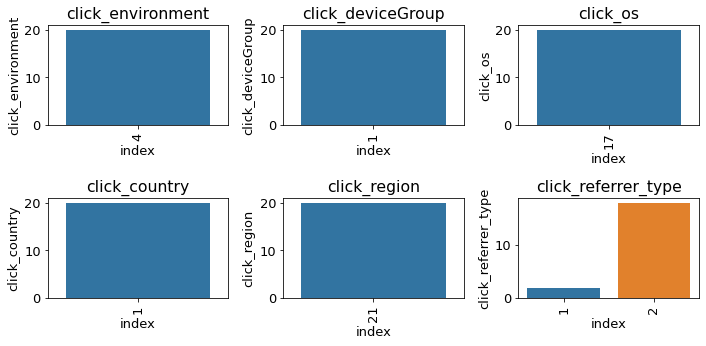

<Figure size 432x288 with 0 Axes>

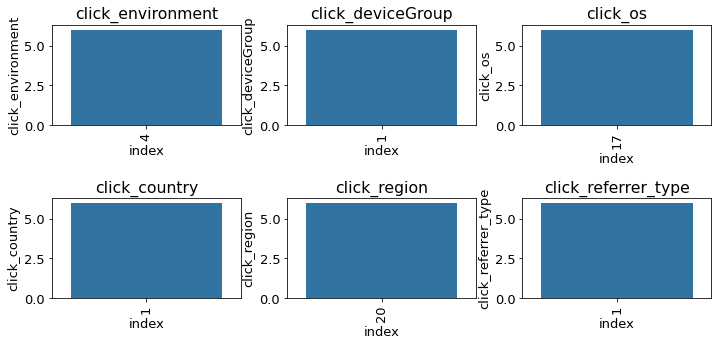

<Figure size 432x288 with 0 Axes>

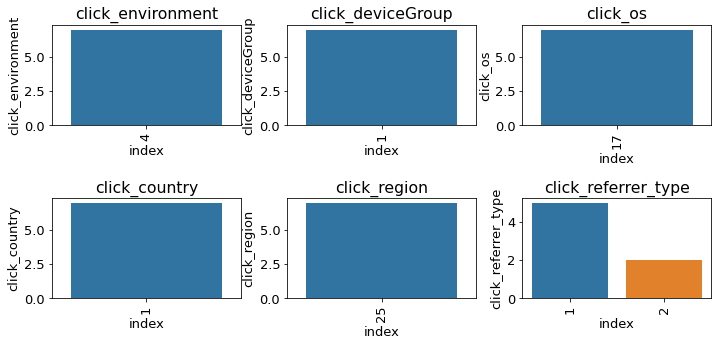

<Figure size 432x288 with 0 Axes>

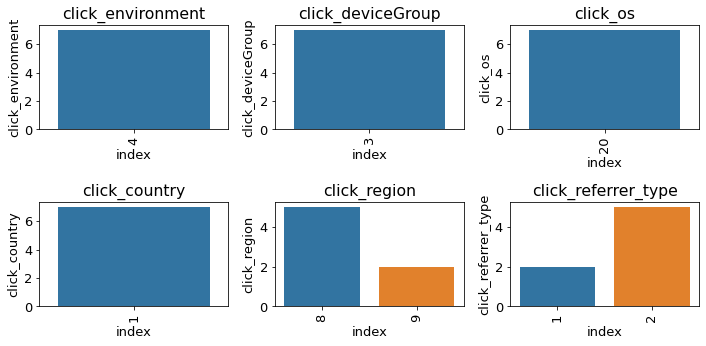

In [36]:
# 分析用户点击环境变化是否明显，这里随机采样10个用户分析这些用户的点击环境分布
sample_user_ids = np.random.choice(tst_click['user_id'].unique(), size=10, replace=False)
sample_users = user_click_merge[user_click_merge['user_id'].isin(sample_user_ids)]
cols = ['click_environment','click_deviceGroup', 'click_os', 'click_country', 'click_region','click_referrer_type']
for _, user_df in sample_users.groupby('user_id'):
    plot_envs(user_df, cols, 2, 3)

#可以看出绝大多数数的用户的点击环境是比较固定的。思路：可以基于这些环境的统计特征来代表该用户本身的属性



#用户点击新闻数量的分布


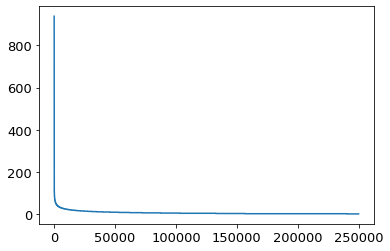

In [37]:
user_click_item_count = sorted(user_click_merge.groupby('user_id')['click_article_id'].count(),reverse = True)
plt.plot(user_click_item_count)

#可以根据用户的点击文章次数看出用户的活跃度

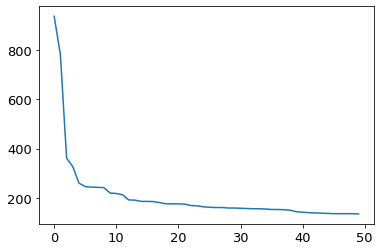

In [38]:
#点击次数在前50的用户
plt.plot(user_click_item_count[:50])

点击次数排前50的用户的点击次数都在100次以上。思路：我们可以定义点击次数大于等于100次的用户为活跃用户，这是一种简单的处理思路， 判断用户活跃度，更加全面的是再结合上点击时间，后面我们会基于点击次数和点击时间两个方面来判断用户活跃度。

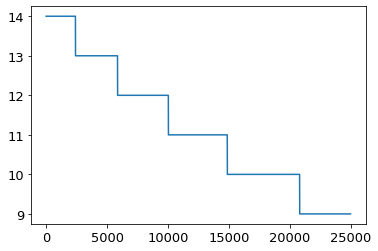

In [39]:
#点击次数排名在【25000：50000】之间
plt.plot(user_click_item_count[25000:50000])

#可以看出点击次数小于等于两次的用户非常的多，这些用户可以认为是非活跃用户

#新闻点击次数分析


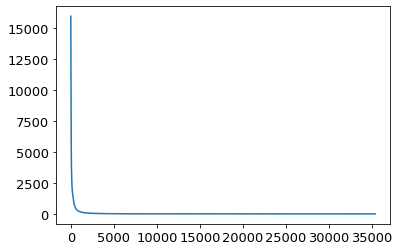

In [40]:
item_click_count = sorted(user_click_merge.groupby('click_article_id')['user_id'].count(), reverse = True)
plt.plot(item_click_count)

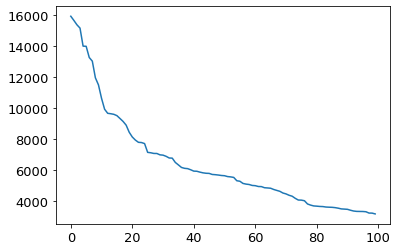

In [41]:
plt.plot(item_click_count[:100])

#可以看出点击次数最多的前100篇新闻，点击次数大于1000次



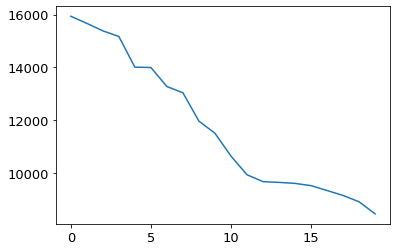

In [42]:
plt.plot(item_click_count[:20])

点击次数最多的前20篇新闻，点击次数大于2500。思路：可以定义这些新闻为热门新闻， 这个也是简单的处理方式，后面我们也是根据点击次数和时间进行文章热度的一个划分。



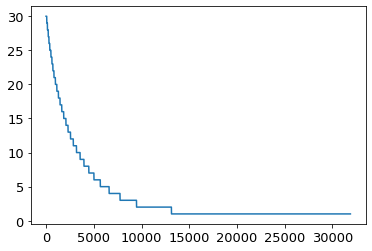

In [43]:
plt.plot(item_click_count[3500:])

可以发现很多新闻只被点击过一两次。思路：可以定义这些新闻是冷门新闻



#新闻共现频次：两篇新闻连续出现的次数


In [44]:
tmp = user_click_merge.sort_values('click_timestamp')
tmp['next_item'] = tmp.groupby(['user_id'])['click_article_id'].transform(lambda x:x.shift(-1))
union_item = tmp.groupby(['click_article_id','next_item'])['click_timestamp'].agg({'count'}).reset_index().sort_values('count', ascending=False)
union_item[['count']].describe()

,count
count,433597.000000
mean,3.184139
std,18.851753
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2202.000000


由统计数据可以看出，平均共现次数3.18，最高为2202。

说明用户看的新闻，相关性是比较强的。

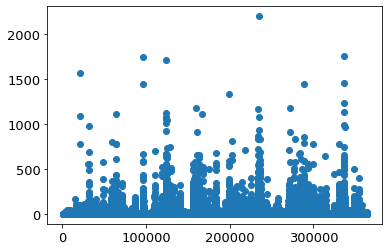

In [45]:
#画个图直观地看一看
x = union_item['click_article_id']
y = union_item['count']
plt.scatter(x, y)

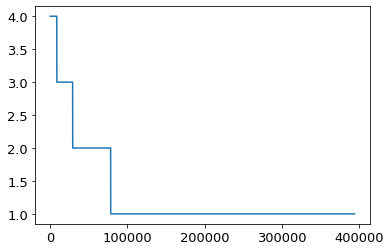

In [46]:
plt.plot(union_item['count'].values[40000:])
#大概有75000个pair至少共现一次

#新闻文章信息


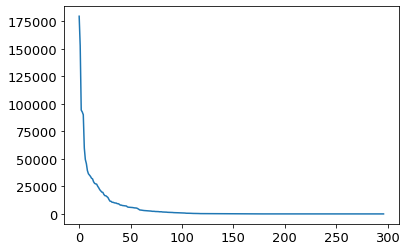

In [47]:
#不同类型的新闻出现的次数
plt.plot(user_click_merge['category_id'].value_counts().values)

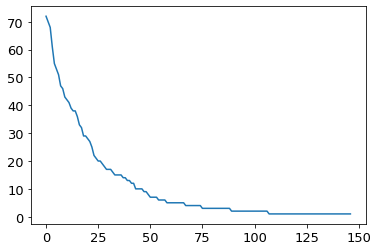

In [48]:
#出现次数比较少的新闻类型, 有些新闻类型，基本上就出现过几次
plt.plot(user_click_merge['category_id'].value_counts().values[150:])

In [49]:
#新闻字数的描述性统计
user_click_merge['words_count'].describe()

count    1.630633e+06
mean     2.043012e+02
std      6.382198e+01
min      0.000000e+00
25%      1.720000e+02
50%      1.970000e+02
75%      2.290000e+02
max      6.690000e+03
Name: words_count, dtype: float64

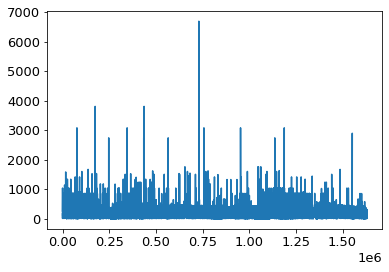

In [50]:
plt.plot(user_click_merge['words_count'].values)

#用户点击的新闻类型的偏好
此特征可以用于度量用户的兴趣是否广泛

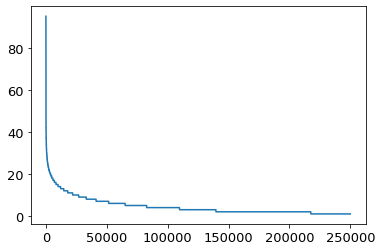

In [51]:
plt.plot(sorted(user_click_merge.groupby('user_id')['category_id'].nunique(), reverse=True))

In [52]:
#从上图中可以看出有一小部分用户阅读类型是极其广泛的，大部分人都处在20个新闻类型以下。
user_click_merge.groupby('user_id')['category_id'].nunique().reset_index().describe()

,user_id,category_id
count,250000.000000,250000.000000
mean,124999.500000,4.573188
std,72168.927986,4.419800
min,0.000000,1.000000
25%,62499.750000,2.000000
50%,124999.500000,3.000000
75%,187499.250000,6.000000
max,249999.000000,95.000000


#用户查看文章的长度的分布
通过统计不同用户点击新闻的平均字数，这个可以反映用户是对长文更感兴趣还是对短文更感兴趣。

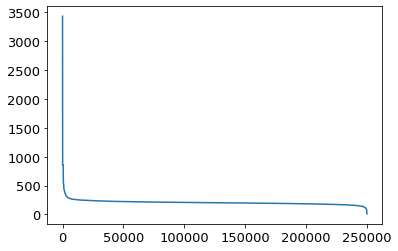

In [53]:
plt.plot(sorted(user_click_merge.groupby('user_id')['words_count'].mean(), reverse=True))
#从上图中可以发现有一小部分人看的文章平均词数非常高，也有一小部分人看的平均文章次数非常低。大多数人偏好于阅读字数在200-400字之间的新闻。

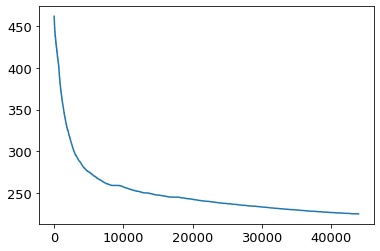

In [54]:
#挑出大多数人的区间仔细看看
plt.plot(sorted(user_click_merge.groupby('user_id')['words_count'].mean(), reverse=True)[1000:45000])#可以发现大多数人都是看250字以下的文章

In [55]:
#更加详细的参数
user_click_merge.groupby('user_id')['words_count'].mean().reset_index().describe()

,user_id,words_count
count,250000.000000,250000.000000
mean,124999.500000,205.830189
std,72168.927986,47.174030
min,0.000000,8.000000
25%,62499.750000,187.500000
50%,124999.500000,202.000000
75%,187499.250000,217.750000
max,249999.000000,3434.500000


#用户点击新闻的时间分析


In [56]:
#为了更好的可视化，这里把时间进行归一化操作
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
user_click_merge['click_timestamp'] = mm.fit_transform(user_click_merge[['click_timestamp']])
user_click_merge['created_at_ts'] = mm.fit_transform(user_click_merge[['created_at_ts']])

user_click_merge = user_click_merge.sort_values('click_timestamp')

In [57]:
user_click_merge.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
18,249990,162300,0.000000,4,3,20,1,25,2,5,5,281,0.989186,193
2,249998,160974,0.000002,4,1,12,1,13,2,5,5,281,0.989092,259
30,249985,160974,0.000003,4,1,17,1,8,2,8,8,281,0.989092,259
50,249979,162300,0.000004,4,1,17,1,25,2,2,2,281,0.989186,193
25,249988,160974,0.000004,4,1,17,1,21,2,17,17,281,0.989092,259


In [58]:
def mean_diff_time_func(df, col):
    df = pd.DataFrame(df, columns={col})
    df['time_shift1'] = df[col].shift(1).fillna(0)
    df['diff_time'] = abs(df[col] - df['time_shift1'])
    return df['diff_time'].mean()

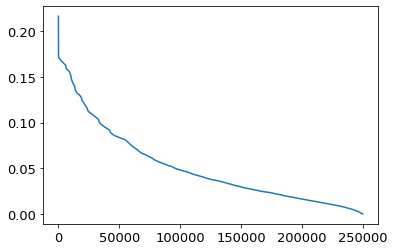

In [59]:
# 点击时间差的平均值
mean_diff_click_time = user_click_merge.groupby('user_id')['click_timestamp', 'created_at_ts'].apply(lambda x: mean_diff_time_func(x, 'click_timestamp'))
plt.plot(sorted(mean_diff_click_time.values, reverse=True))#从上图可以发现不同用户点击文章的时间差是有差异的

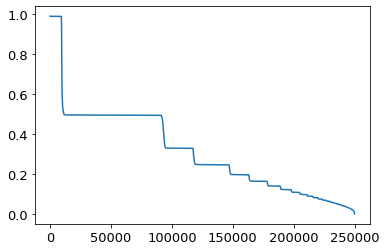

In [60]:
# 前后点击文章的创建时间差的平均值
mean_diff_created_time = user_click_merge.groupby('user_id')['click_timestamp', 'created_at_ts'].apply(lambda x: mean_diff_time_func(x, 'created_at_ts'))
plt.plot(sorted(mean_diff_created_time.values, reverse=True))#从图中可以发现用户先后点击文章，文章的创建时间也是有差异的

In [61]:
#从图中可以发现用户先后点击文章，文章的创建时间也是有差异的
# 安装gensim
!pip install gensim


In [62]:
from gensim.models import Word2Vec
import logging, pickle

# 需要注意这里模型只迭代了一次
def trian_item_word2vec(click_df, embed_size=16, save_name='item_w2v_emb.pkl', split_char=' '):
    click_df = click_df.sort_values('click_timestamp')
    # 只有转换成字符串才可以进行训练
    click_df['click_article_id'] = click_df['click_article_id'].astype(str)
    # 转换成句子的形式
    docs = click_df.groupby(['user_id'])['click_article_id'].apply(lambda x: list(x)).reset_index()
    docs = docs['click_article_id'].values.tolist()

    # 为了方便查看训练的进度，这里设定一个log信息
    logging.basicConfig(format='%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)

    # 这里的参数对训练得到的向量影响也很大,默认负采样为5
    w2v = Word2Vec(docs, size=16, sg=1, window=5, seed=2020, workers=24, min_count=1, iter=10)
    
    # 保存成字典的形式
    item_w2v_emb_dict = {k: w2v[k] for k in click_df['click_article_id']}
    
    return item_w2v_emb_dict

In [63]:
item_w2v_emb_dict = trian_item_word2vec(user_click_merge)

2022-02-16 05:17:29,190:INFO:collecting all words and their counts
2022-02-16 05:17:29,198:INFO:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-02-16 05:17:29,219:INFO:PROGRESS: at sentence #10000, processed 25727 words, keeping 3473 word types
2022-02-16 05:17:29,245:INFO:PROGRESS: at sentence #20000, processed 53883 words, keeping 5811 word types
2022-02-16 05:17:29,281:INFO:PROGRESS: at sentence #30000, processed 84881 words, keeping 7676 word types
2022-02-16 05:17:29,313:INFO:PROGRESS: at sentence #40000, processed 118390 words, keeping 9297 word types
2022-02-16 05:17:29,345:INFO:PROGRESS: at sentence #50000, processed 154179 words, keeping 10844 word types
2022-02-16 05:17:29,373:INFO:PROGRESS: at sentence #60000, processed 192350 words, keeping 12357 word types
2022-02-16 05:17:29,408:INFO:PROGRESS: at sentence #70000, processed 233685 words, keeping 13473 word types
2022-02-16 05:17:29,454:INFO:PROGRESS: at sentence #80000, processed 281335 words, keepin

In [64]:
# 随机选择5个用户，查看这些用户前后查看文章的相似性
sub_user_ids = np.random.choice(user_click_merge.user_id.unique(), size=15, replace=False)
sub_user_info = user_click_merge[user_click_merge['user_id'].isin(sub_user_ids)]

sub_user_info.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
37293,235538,300470,0.003315,4,1,17,1,18,2,17,17,428,0.989182,203
37294,235538,225463,0.003429,4,1,17,1,18,2,16,17,354,0.989195,220
37295,235538,337082,0.003437,4,1,17,1,18,2,15,17,437,0.989214,163
81105,219783,336607,0.006757,4,1,17,1,24,1,1,1,437,0.989230,173
4690,198289,36605,0.020581,4,1,17,1,8,2,5,5,43,0.989176,157


In [65]:
# 上一个版本，这个函数使用的是赛题提供的词向量，但是由于给出的embedding并不是所有的数据的embedding，所以运行下面画图函数的时候会报keyerror的错误
# 为了防止出现这个错误，这里修改为使用word2vec训练得到的词向量进行可视化
def get_item_sim_list(df):
    sim_list = []
    item_list = df['click_article_id'].values
    for i in range(0, len(item_list)-1):
        emb1 = item_w2v_emb_dict[str(item_list[i])] # 需要注意的是word2vec训练时候使用的是str类型的数据
        emb2 = item_w2v_emb_dict[str(item_list[i+1])]
        sim_list.append(np.dot(emb1,emb2)/(np.linalg.norm(emb1)*(np.linalg.norm(emb2))))
    sim_list.append(0)
    return sim_list

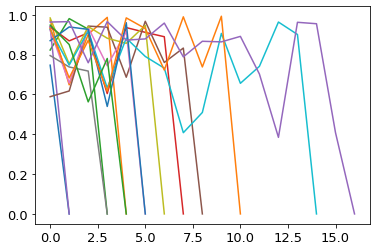

In [66]:
for _, user_df in sub_user_info.groupby('user_id'):
    item_sim_list = get_item_sim_list(user_df)
    plt.plot(item_sim_list)

这里由于对词向量的训练迭代次数不是很多，所以看到的可视化结果不是很准确，可以训练更多次来观察具体的现象。



#总结

1.   训练集和测试集的用户id没有重复，也就是测试集里面的用户模型是没有见过的
2.   训练集中用户最少的点击文章数是2， 而测试集里面用户最少的点击文章数是1
3.   用户对于文章存在重复点击的情况， 但这个都存在于训练集里面
4.同一用户的点击环境存在不唯一的情况，后面做这部分特征的时候可以采用统计特征
5.用户点击文章的次数有很大的区分度，后面可以根据这个制作衡量用户活跃度的特征
6.文章被用户点击的次数也有很大的区分度，后面可以根据这个制作衡量文章热度的特征
7.用户看的新闻，相关性是比较强的，所以往往我们判断用户是否对某篇文章感兴趣的时候候，在很大程度上会和他历史点击过的文章有关
8.用户点击的文章字数有比较大的区别， 这个可以反映用户对于文章字数的区别
9.用户点击过的文章主题也有很大的区别， 这个可以反映用户的主题偏好 10.不同用户点击文章的时间差也会有所区别， 这个可以反映用户对于文章时效性的偏好






